In [498]:
%load_ext autoreload
# import datetime
# import ete3
# import itertools
import json
import logging
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
# import os
import pandas as pd
import typing
# import re
import xml.etree.ElementTree as ET
# import xml.dom.minidom
# import xmlschema
import pm4py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload
from maxes.xes_loader2 import XesLoader
# from maxes.xes_file import XesFile
# from maxes.analyze_xes import AnalyzeXes
# import maxes.analyze_sequence
# import maxes.serialization.serialize
# import maxes.graphs
import maxes.notebooks.utils
# import maxes.utils
# from maxes.analyze_xes import AnalyzeXes

In [ ]:
maxes.notebooks.utils.init_notebook() # RUN ONLY ONCE

In [6]:
%autoreload
from maxes.xes_loader2 import XesLoader
import maxes.notebooks.utils

file_path = maxes.notebooks.utils.get_data_path('other/event_log.xes')

log = XesLoader().load(file_path)
log.df

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,instance,Order ID,action,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,,complete,2023-12-31 23:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1,1.0,Receive customer order,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1,1,,complete,2023-12-31 23:14:11+00:00,Plan,"[laptop,desktop]",2,2.0,Receive customer order,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
2,1,,complete,2023-12-31 23:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1,1.0,Try payment,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
3,1,,complete,2023-12-31 23:16:01+00:00,Plan,"[laptop,desktop]",2,2.0,Deny order,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
4,1,,complete,2023-12-31 23:16:01+00:00,Credit,[phone],3,3.0,Receive customer order,Order,Order,Gold,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31250,1,,complete,2024-01-31 22:50:39+00:00,Plan,"[tv,desktop]",2970,2970.0,Complete packing,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31251,1,,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998,2998.0,Pick inventory,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31252,1,,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998,2998.0,Pick inventory,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31253,1,,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998,2998.0,Pick inventory,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
%autoreload
from maxes.utils import reorder_xes_columns

log_df_processed = (
    log.df
    .copy()
    .drop(columns=['case:concept:name', 'concept:name'])
    .rename(columns={'instance': 'case:concept:name', 'action': 'concept:name'})
    .sort_values(by=['case:concept:name', 'time:timestamp'])
    .reset_index(drop=True)
)

# reorder columns
log_df_processed = reorder_xes_columns(log_df_processed)

log_df_processed

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,Receive customer order,complete,2023-12-31 23:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Try payment,complete,2023-12-31 23:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Receive payment,complete,2023-12-31 23:19:10+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Process order,complete,2023-12-31 23:24:14+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Pick inventory,complete,2024-01-01 00:04:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31250,2998,Process order,complete,2024-01-31 22:16:24+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31251,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31252,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31253,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [399]:
%autoreload
from maxes.log_builder import LogBuilder

log_builder = LogBuilder()
log_processed = log_builder.build_log(log_df_processed)
log_processed

In [415]:
log_processed.update_df()
log_processed.df

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,Receive customer order,complete,2023-12-31 23:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Try payment,complete,2023-12-31 23:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Receive payment,complete,2023-12-31 23:19:10+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Process order,complete,2023-12-31 23:24:14+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Pick inventory,complete,2024-01-01 00:04:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2998,Process order,complete,2024-01-31 22:16:24+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
4,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
5,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
6,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
len(log_processed.traces)

2999

In [514]:
%autoreload
from maxes.generators.xes_generator.xes_generator3 import XesGenerator3 as XesGenerator

generator = XesGenerator(generate_traces_count=1, debug=True)
generator.fit(log_processed)

In [511]:
generator.event_attributes_info_df()

,name,level,xes_type,presence,numeralicity,is_trace_identifier
0,concept:name,None,XesTypeEnum.STRING,NaN,None,None
1,lifecycle:transition,None,XesTypeEnum.STRING,NaN,None,None
2,time:timestamp,None,XesTypeEnum.STRING,NaN,None,None
3,Payment type,AttributeLevelEnum.EVENT,XesTypeEnum.STRING,0.850520,None,False
4,Products,AttributeLevelEnum.TRACE,XesTypeEnum.STRING,0.850520,None,False
5,Order ID,AttributeLevelEnum.TRACE,XesTypeEnum.STRING,0.850520,None,True
6,model,AttributeLevelEnum.EVENT,XesTypeEnum.STRING,1.000000,None,False
7,type,AttributeLevelEnum.EVENT,XesTypeEnum.STRING,1.000000,None,False
8,Customer type,AttributeLevelEnum.TRACE,XesTypeEnum.STRING,0.850520,None,False
9,Number of orders,AttributeLevelEnum.EVENT,XesTypeEnum.STRING,0.132299,None,False


In [515]:
generator.generate_traces_count = 10
result_log = generator.sample(1)[0]
reorder_xes_columns(result_log.df)
# result_log.df

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Products,Customer type,Payment type,model,type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,0,Receive customer order,complete,2024-01-27 01:45:58.377941+00:00,"[phone,phone]",Gold,Credit,Order,Order,NaN,NaN,NaN,NaN,NaN,NaN
1,0,Try payment,complete,2024-01-27 02:00:55.791291+00:00,"[phone,phone]",Gold,Debit,Order,Order,NaN,NaN,NaN,NaN,NaN,NaN
2,0,Receive payment,complete,2024-01-27 02:05:49.033896+00:00,"[phone,phone]",Gold,Credit,Order,Order,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Process order,complete,2024-01-27 02:10:44.561367+00:00,"[phone,phone]",Gold,Credit,Order,Order,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Pick backorder,complete,2024-01-27 08:37:50.370305+00:00,"[phone,phone]",Gold,Credit,Order,Order,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,9,Deny order,complete,2024-01-17 15:43:11.148981+00:00,"[laptop,phone,desktop]",Silver,Credit,Order,Order,NaN,NaN,NaN,NaN,NaN,NaN
112,9,Create shipment,complete,2024-01-18 10:24:23.086120+00:00,NaN,NaN,NaN,Shipment,Shipment,5.0,NaN,Courier C,NaN,NaN,NaN
113,9,Load products,complete,2024-01-18 10:34:21.242945+00:00,NaN,NaN,NaN,Shipment,Shipment,5.0,NaN,Courier C,NaN,NaN,NaN
114,9,Start shipment,complete,2024-01-18 11:34:39.036605+00:00,NaN,NaN,NaN,Shipment,Shipment,5.0,NaN,Courier C,NaN,NaN,NaN


In [518]:
del result_log.event_attributes_info['Order ID']

result_log.event_attributes_info

{'concept:name': <maxes.xes_log.AttributeInfo at 0x3bdf832f0>,
 'time:timestamp': <maxes.xes_log.AttributeInfo at 0x3bdf831d0>,
 'lifecycle:transition': <maxes.xes_log.AttributeInfo at 0x3bdf81fd0>,
 'Payment type': <maxes.xes_log.AttributeInfo at 0x3bd42a0f0>,
 'Products': <maxes.xes_log.AttributeInfo at 0x3bd42b710>,
 'model': <maxes.xes_log.AttributeInfo at 0x3bd42bcb0>,
 'type': <maxes.xes_log.AttributeInfo at 0x3bd42b410>,
 'Customer type': <maxes.xes_log.AttributeInfo at 0x3bd42b950>,
 'Number of orders': <maxes.xes_log.AttributeInfo at 0x3bd42bd10>,
 'Shipment ID': <maxes.xes_log.AttributeInfo at 0x3bd42a690>,
 'Courier': <maxes.xes_log.AttributeInfo at 0x3bd8d8830>,
 'Amount': <maxes.xes_log.AttributeInfo at 0x3bd8d8890>,
 'Replenishment ID': <maxes.xes_log.AttributeInfo at 0x3bd8d8b30>,
 'Product': <maxes.xes_log.AttributeInfo at 0x3bd8d8950>}

In [519]:
result_log.update_traces_from_df()

In [503]:
result_log.event_attributes_info

{'Payment type': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bf8fe2b0>,
 'model': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bef32a30>,
 'type': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bef32850>,
 'Number of orders': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bef31a90>,
 'Shipment ID': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bef31bd0>,
 'Courier': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bef32170>,
 'Amount': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bef31f90>,
 'Replenishment ID': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bef31db0>,
 'Product': <maxes.generators.xes_generator.xes_generator3.AttributeInfo at 0x3bef31c70>}

In [520]:
# Serialize

%autoreload

import os

from maxes.serialization.serialize import Serializer

generated_log_ET = Serializer().serialize(result_log)

ET.indent(generated_log_ET)
ET.register_namespace("", "http://www.xes-standard.org")

generated_log_path = os.path.join(maxes.notebooks.utils.get_project_path(), "output/event_log.xes")
with open(generated_log_path, "w") as file:
    generated_log_ET.write(file, encoding="unicode")

result_log

,concept:name
0,Receive customer order
1,Try payment
2,Receive payment
3,Process order
4,Pick inventory
5,Pick backorder
6,Pack order
7,Complete packing
8,Deliver order


In [485]:
X = result_log.df[['concept:name']]
attribute_info = generator.event_attributes_info['Payment type']
y = attribute_info.predictor.predict(X)
y = attribute_info.encoder.inverse_transform(y)
y

array(['Plan', 'Plan', 'Plan', 'Debit', 'Debit', 'Credit', 'Debit',
       'Debit', nan], dtype=object)

In [486]:
result_log.df[attribute_info.name] = y
result_log.df

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Products,Customer type,Payment type
0,0,Receive customer order,complete,2024-01-13 18:43:47.991488+00:00,"[desktop,desktop]",Silver,Plan
1,0,Try payment,complete,2024-01-13 19:00:39.575169+00:00,"[desktop,desktop]",Silver,Plan
2,0,Receive payment,complete,2024-01-13 19:05:35.853702+00:00,"[desktop,desktop]",Silver,Plan
3,0,Process order,complete,2024-01-13 19:10:38.485182+00:00,"[desktop,desktop]",Silver,Debit
4,0,Pick inventory,complete,2024-01-13 19:40:24.082415+00:00,"[desktop,desktop]",Silver,Debit
5,0,Pick backorder,complete,2024-01-14 01:45:28.333055+00:00,"[desktop,desktop]",Silver,Credit
6,0,Pack order,complete,2024-01-14 08:46:50.562638+00:00,"[desktop,desktop]",Silver,Debit
7,0,Complete packing,complete,2024-01-14 09:01:56.546130+00:00,"[desktop,desktop]",Silver,Debit
8,0,Deliver order,complete,2024-01-14 14:10:28.034161+00:00,NaN,NaN,NaN


In [467]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

df = generator.log_df_
# df['Payment type'].value_counts().sum()

attribute = 'Payment type'
notnull = df[df[attribute].notna()]

X = df[['concept:name']]
# y = df['model']
y = df[attribute]


steps = [
    ("OneHotEncoder", OneHotEncoder()),
    ("MLPClassifier", MLPClassifier()),
]

# output_encoder = OneHotEncoder()
output_encoder = LabelEncoder()
y = df[attribute].to_numpy()
# y = y.reshape((y.shape[0], 1))
y = output_encoder.fit_transform(y)
print(y)
print(pd.Series(y).value_counts())
# print(y.toarray())
model = Pipeline(steps)
model.fit(X, y)

[0 0 0 ... 2 2 2]
0    8953
1    8889
2    8741
3    4672
Name: count, dtype: int64


Pipeline(steps=[('OneHotEncoder', OneHotEncoder()),
                ('MLPClassifier', MLPClassifier())])

In [470]:
# X_test = [['Process order']]

X_test = pd.DataFrame([['Process order'], ['Load products'], ['Start shipment']], columns=['concept:name'])

# X_test = df[['concept:name']][0]
result = model.predict(X_test)
# print(result.toarray())
print(result)
output_encoder.inverse_transform(result)

[0 3 3]


array(['Credit', nan, nan], dtype=object)

In [457]:
array = df['Payment type'].to_numpy()
array.reshape((array.shape[0], 1))


output_encoder = OneHotEncoder()
y = df[attribute].to_numpy()
# print(y)
y = y.reshape((y.shape[0], 1))
y = output_encoder.fit_transform(y)
y.toarray()
# array[:, 2]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [460]:
y.shape

(31255, 4)

In [315]:
%autoreload
from maxes.models.models import WeightedSampler

a = pd.DataFrame([['a'], ['a'], ['b'], ['b'], ['b']], columns=['aa'])
# print(isinstance(a, pd.DataFrame))
sampler = WeightedSampler().fit(a['aa'])
sampler.sample(10)

{'b': 3, 'a': 2}
<class 'dict'>


0    b
1    a
2    b
3    a
4    b
5    b
6    b
7    b
8    a
9    a
dtype: object

In [373]:
a = pd.DataFrame([['a', 1], ['a', 2], ['b', 3], ['b', 4], ['b', 5]], columns=['aa', 'ab'])
b = pd.DataFrame([['1'], ['2']], columns=['bb'])
mask = pd.DataFrame([[True], [False], [False], [True], [False]], columns=['m'])


b['aa'] = a.groupby('aa').first().reset_index()['aa']
# a.groupby('aa').first().reset_index()
# b

# a.join(b, on='aa')

r = pd.merge(a, b, on='aa')

r['bb'] = r['bb'][mask['m']]
# r["bb"] = mask['m']

r

# a.groupby('aa').value

# result = []

# for i, (index, group) in enumerate(a.groupby('aa')):
#     group['bb'] = b[i]
#     result.append(group)

# result = pd.concat(result)
# result

# a['bb'] = b[a.groupby('aa').ngroup()]
# a['bb']
# a

,aa,ab,bb
0,a,1,1
1,a,2,NaN
2,b,3,NaN
3,b,4,2
4,b,5,NaN


In [336]:
# a.reindex(['aa'])
a.set_index(['aa'])

""
aa
a
a
b
b
b


# TODO: Document

most likely, generator generates shorter traces than original log traces

In [304]:
generator.generate_traces_count = 100
result = generator.sample(1)

[len(trace.events) for trace in result[0].traces]

# reorder_xes_columns(result_log.df)


[10,
 8,
 12,
 9,
 8,
 9,
 10,
 11,
 11,
 9,
 11,
 11,
 10,
 9,
 8,
 11,
 9,
 22,
 26,
 11,
 8,
 9,
 8,
 11,
 9,
 6,
 7,
 14,
 9,
 9,
 9,
 9,
 8,
 35,
 8,
 8,
 26,
 10,
 10,
 10,
 10,
 10,
 12,
 12,
 10,
 9,
 11,
 8,
 9,
 10,
 9,
 8,
 8,
 6,
 9,
 8,
 13,
 28,
 8,
 13,
 12,
 11,
 8,
 6,
 12,
 10,
 9,
 8,
 8,
 8,
 10,
 9,
 10,
 10,
 12,
 10,
 9,
 8,
 11,
 10,
 9,
 10,
 9,
 8,
 11,
 9,
 8,
 9,
 10,
 11,
 11,
 12,
 23,
 8,
 8,
 6,
 7,
 8,
 8,
 10]

In [145]:
len(result_log.traces)

100

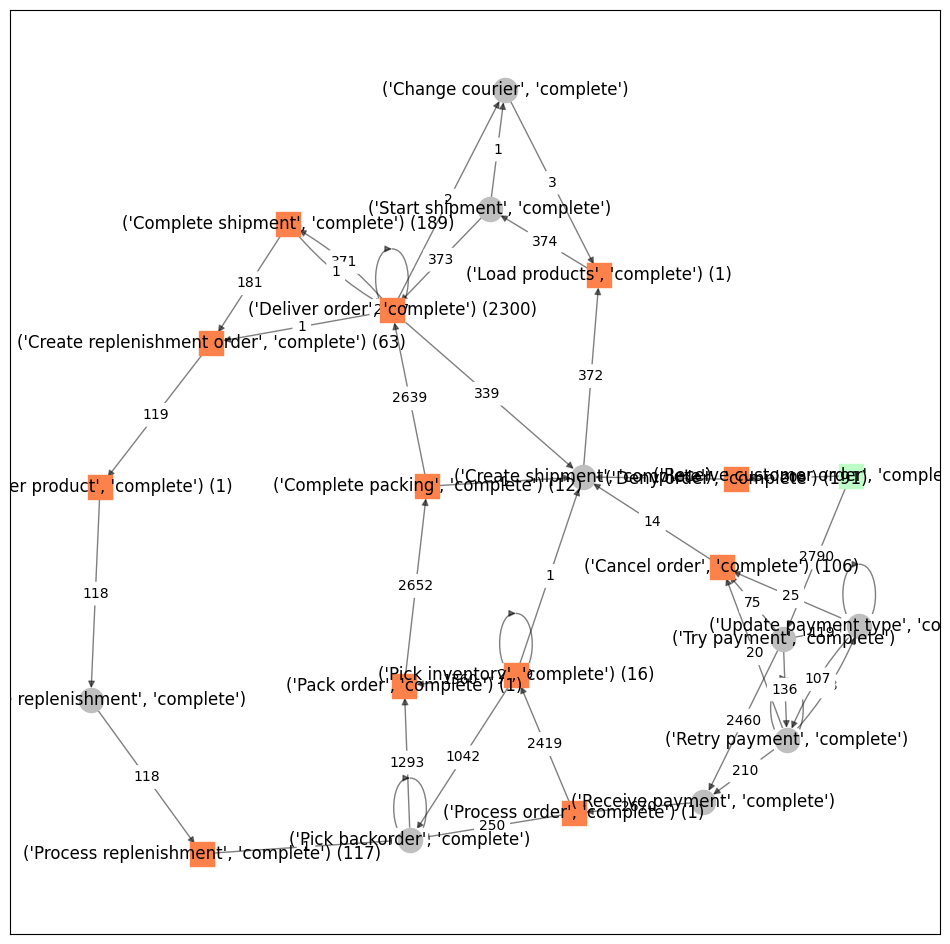

In [142]:
from maxes.analyze_sequence import draw_nx_graph

fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

graph = generator.sequence_graph_
draw_nx_graph(graph, ax=ax, pos=nx.kamada_kawai_layout(graph), edge_label="frequency")

In [86]:
result_log[0].df

,Amount,Courier,Customer type,Number of orders,Order ID,Payment type,Product,Products,Replenishment ID,Shipment ID,concept:name,lifecycle:transition,model,time:timestamp,type
0,False,False,True,False,True,True,False,True,False,False,Receive customer order,complete,True,2024-01-17 09:58:05.369152+00:00,True
1,False,False,True,False,True,True,False,True,False,False,Try payment,complete,True,2024-01-17 10:21:35.307100+00:00,True
2,False,False,True,False,True,True,False,True,False,False,Receive payment,complete,True,2024-01-17 10:26:44.290252+00:00,True
3,False,False,True,False,True,True,False,True,False,False,Process order,complete,True,2024-01-17 10:31:57.808502+00:00,True


In [ ]:
result_df = log_processed.df[['case:concept:name', 'concept:name', 'lifecycle:transition', 'time:timestamp']].copy()

X = log_processed.df[['concept:name']].copy()

for attribute_info in generator.event_attributes_info.values():
    attribute = attribute_info.name
    print(attribute)

    model = attribute_info.presence_model

    if model is None: continue

    result_df[attribute] = model.predict(X)

result_df

concept:name
lifecycle:transition
time:timestamp
Payment type
Products
Order ID
model
type
Customer type
Number of orders
Shipment ID
Courier
Amount
Replenishment ID
Product


,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,Receive customer order,complete,2023-12-31 23:02:57+00:00,True,True,True,True,True,True,False,False,False,False,False,False
1,1,Try payment,complete,2023-12-31 23:14:11+00:00,True,True,True,True,True,True,False,False,False,False,False,False
2,1,Receive payment,complete,2023-12-31 23:19:10+00:00,True,True,True,True,True,True,False,False,False,False,False,False
3,1,Process order,complete,2023-12-31 23:24:14+00:00,True,True,True,True,True,True,False,False,False,False,False,False
4,1,Pick inventory,complete,2024-01-01 00:04:11+00:00,True,True,True,True,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2998,Process order,complete,2024-01-31 22:16:24+00:00,True,True,True,True,True,True,False,False,False,False,False,False
4,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,True,True,True,True,True,True,False,False,False,False,False,False
5,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,True,True,True,True,True,True,False,False,False,False,False,False
6,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,True,True,True,True,True,True,False,False,False,False,False,False


In [70]:
a = pd.DataFrame([[1], [2], [3], [4], [5]], columns=['aa'])
b = pd.DataFrame([['a'], ['b'], ['c'], ['d'], ['e']], columns=['bb'])

# result = pd.concat([a, b], axis=1)
result = a.combine_first(b)
result

,aa,bb
0,1,a
1,2,b
2,3,c
3,4,d
4,5,e


In [68]:
result.columns

Index(['aa', 'aa'], dtype='object')

In [28]:
df = log_processed.df
df

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,Receive customer order,complete,2023-12-31 23:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Try payment,complete,2023-12-31 23:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Receive payment,complete,2023-12-31 23:19:10+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Process order,complete,2023-12-31 23:24:14+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Pick inventory,complete,2024-01-01 00:04:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2998,Process order,complete,2024-01-31 22:16:24+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
4,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
5,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
6,2998,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
nunique_per_log = df.nunique()
nunique_per_log

case:concept:name        2999
concept:name               22
lifecycle:transition        1
time:timestamp          23690
Payment type                3
Products                  323
Order ID                 2999
model                       3
type                        3
Customer type               3
Number of orders            3
Shipment ID               372
Courier                     3
Amount                     90
Replenishment ID          182
Product                     4
dtype: int64

In [29]:
nunique_per_trace = df.groupby('case:concept:name').nunique()
nunique_per_trace

,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
case:concept:name,,,,,,,,,,,,,,,
1,17,1,22,1,1,1,3,3,1,1,1,1,1,1,1
2,11,1,15,1,1,1,3,3,1,1,1,1,1,1,1
3,16,1,21,1,1,1,3,3,1,1,1,1,1,1,1
4,14,1,19,1,1,1,3,3,1,1,1,1,1,1,1
5,13,1,23,1,1,1,3,3,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,5,1,5,1,1,1,1,1,1,0,0,0,0,0,0
2996,5,1,5,1,1,1,1,1,1,0,0,0,0,0,0
2997,4,1,4,1,1,1,1,1,1,0,0,0,0,0,0


In [31]:
is_trace_level = (nunique_per_trace == 1).all()
is_trace_level

concept:name            False
lifecycle:transition     True
time:timestamp          False
Payment type            False
Products                 True
Order ID                 True
model                   False
type                    False
Customer type            True
Number of orders        False
Shipment ID             False
Courier                 False
Amount                  False
Replenishment ID        False
Product                 False
dtype: bool

In [32]:
is_unique_per_trace = nunique_per_log == 2999
is_unique_per_trace

case:concept:name        True
concept:name            False
lifecycle:transition    False
time:timestamp          False
Payment type            False
Products                False
Order ID                 True
model                   False
type                    False
Customer type           False
Number of orders        False
Shipment ID             False
Courier                 False
Amount                  False
Replenishment ID        False
Product                 False
dtype: bool

In [143]:
%autoreload
from maxes.generators.xes_generator.algorithms import guess_xes_attributes_levels

guess_xes_attributes_levels(log_processed.df)

{'model': <AttributeLevelEnum.EVENT: 'event'>,
 'Order ID': <AttributeLevelEnum.TRACE: 'trace'>,
 'type': <AttributeLevelEnum.EVENT: 'event'>,
 'Amount': <AttributeLevelEnum.EVENT: 'event'>,
 'Payment type': <AttributeLevelEnum.EVENT: 'event'>,
 'Number of orders': <AttributeLevelEnum.EVENT: 'event'>,
 'Courier': <AttributeLevelEnum.EVENT: 'event'>,
 'Products': <AttributeLevelEnum.TRACE: 'trace'>,
 'Replenishment ID': <AttributeLevelEnum.EVENT: 'event'>,
 'Shipment ID': <AttributeLevelEnum.EVENT: 'event'>,
 'Customer type': <AttributeLevelEnum.TRACE: 'trace'>,
 'Product': <AttributeLevelEnum.EVENT: 'event'>,
 'case:concept:name': <AttributeLevelEnum.EVENT: 'event'>,
 'concept:name': <AttributeLevelEnum.EVENT: 'event'>,
 'lifecycle:transition': <AttributeLevelEnum.EVENT: 'event'>,
 'time:timestamp': <AttributeLevelEnum.EVENT: 'event'>}

In [140]:
df = log_processed.df

nunique_per_case_df = df.groupby("case:concept:name")[['concept:name', 'model', 'Customer type']].nunique()
nunique_per_case_df
# value_counts = nunique_per_case_df.value_counts()
# len(value_counts)

,concept:name,model,Customer type
case:concept:name,,,
1,17,3,1
2,11,3,1
3,16,3,1
4,14,3,1
5,13,3,1
...,...,...,...
2995,5,1,1
2996,5,1,1
2997,4,1,1


In [141]:
nunique_per_case_df['Customer type'].value_counts()

Customer type
1    2999
Name: count, dtype: int64

In [133]:
trace_level_columns = value_counts.filter(1).keys()
trace_level_columns

TypeError: Index(...) must be called with a collection of some kind, 1 was passed

In [93]:
generator.log_df_

,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product,case:case:concept:name
0,Receive customer order,complete,2023-12-31 23:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x34d4f0...
1,Try payment,complete,2023-12-31 23:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x34d4f0...
2,Receive payment,complete,2023-12-31 23:19:10+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x34d4f0...
3,Process order,complete,2023-12-31 23:24:14+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x34d4f0...
4,Pick inventory,complete,2024-01-01 00:04:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x34d4f0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,Process order,complete,2024-01-31 22:16:24+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x381154...
4,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x381154...
5,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x381154...
6,Pick inventory,complete,2024-01-31 22:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN,<maxes.xes_log.XesAttribute object at 0x381154...


In [46]:
# log.df.columns - [CONCEPT_NAME]
set(log.df.columns) - {CONCEPT_NAME}

{'Amount',
 'Courier',
 'Customer type',
 'Number of orders',
 'Order ID',
 'Payment type',
 'Product',
 'Products',
 'Replenishment ID',
 'Shipment ID',
 'action',
 'instance',
 'lifecycle:transition',
 'model',
 'time:timestamp',
 'type'}